In [1]:
%%bash

echo -e "\nIn progress ...\n"

date +"%Y-%m-%d %T"

echo -e "\n"


In progress ...

2020-12-09 14:55:59





# Introduction

This notebook estimates the underlying model of a data set via linear models, i.e., it is hypothesised that the underlying data model is linear.  Remember, the term **weights** refers to the parameters of a model, i.e., $\:m$ & $c\:$ in $\:y = mx + c$

<br>

**Help Notes**

* Graphing:

  * [add_subplot](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.add_subplot), &nbsp; [.plot](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot),  &nbsp; [.legend](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.legend.html#matplotlib.pyplot.legend),  &nbsp; [.xlabel & .ylabel](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure)


* Distributions of observed values:

  * [Kernel Density Estimation Graphs](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)

  * [Kernel Density Estimation](https://seaborn.pydata.org/tutorial/distributions.html#kernel-density-estimation)


<br>
<br>

# Preliminaries

Cleaning-up

In [2]:
!rm -rf *.sh

<br>

## Packages, Paths, Libraries

**Packages**

Downloading packages from GitHub

In [3]:
import subprocess

In [4]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/plausibilities/fundamentals/develop/scripts.sh', 
                   shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

**Paths**

In [5]:
import os
import pathlib
import sys

In [6]:
if not 'google.colab' in str(get_ipython()):
    
    notebooks = os.path.split(os.getcwd())[0]
    parent = str(pathlib.Path(notebooks).parent.parent)
    sys.path.append(parent)

In [7]:
pathofdiagrams = 'contrasts'

if not os.path.exists(path=pathofdiagrams):
    os.makedirs(pathofdiagrams)

<br>

**Libraries**

In [8]:
import arviz as az
import graphviz
import pymc3 as pm

import logging
import collections

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import theano


In [9]:
pm.__version__

'3.9.3'

<br>

Custom

In [10]:
import fundamentals.graphics.settings
import fundamentals.graphics.relational

import fundamentals.samples.linear

<br>

**Generic Instances**

A relational graph instance, and its labels class

In [11]:
relational = fundamentals.graphics.relational.Relational()

RelationalGraphLabels = collections.namedtuple(
    typename='RelationalGraphLabels', field_names=['title', 'xlabel', 'ylabel'])

<br>

## Set-up

**Display**

If the display screen supports **retina display**, a figure's resolution can be enhanced via

In [12]:
%config InlineBackend.figure_format = 'retina'

<br>

**Layout & Aesthetics**


In [13]:
settings = fundamentals.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

## Logging

In [14]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

<br>
<br>

# Data


Underlying model  $\: mX + c \:$ for $\: \rightarrow$

* $Y = mX + c + \mathcal{E}$

wherein

* $Y$: $N \times 1$
* $X$: $N \times 1$
* $m$: $1 \times 1$, the gradient 
* $\;\: c$: $1 \times 1$, the intercept
* $\; \mathcal{E}$: $N \times 1$, residuals | noise | errors

<br>

## Sample

Parameters for sampling

In [15]:
Parameters = collections.namedtuple(typename='Parameters', 
                                    field_names=['N', 'F', 'range', 'intercept', 'gradient', 'noiseloc', 'noisescale'])

parameters = Parameters._make([100, 100, (0, 2), 1.0, 2.0, 0.0, 0.5])

logger.info('The # of observations points\n{}\n'.format(parameters.N))
logger.info('The # of future points to predict\n{}\n'.format(parameters.F))

INFO:__main__:The # of observations points
100

INFO:__main__:The # of future points to predict
100



<br>

Hence, the sample of data

In [16]:
linear = fundamentals.samples.linear.Linear(parameters=parameters)

data = linear.exc()

logger.info('The # of independent variable/s instances\n{}\n'.format(data.independent.shape))
logger.info('The # of dependent variable/s instances\n{}\n'.format(data.dependent.shape))

INFO:__main__:The # of independent variable/s instances
(100, 1)

INFO:__main__:The # of dependent variable/s instances
(100, 1)



<br>

## Illustration

The data

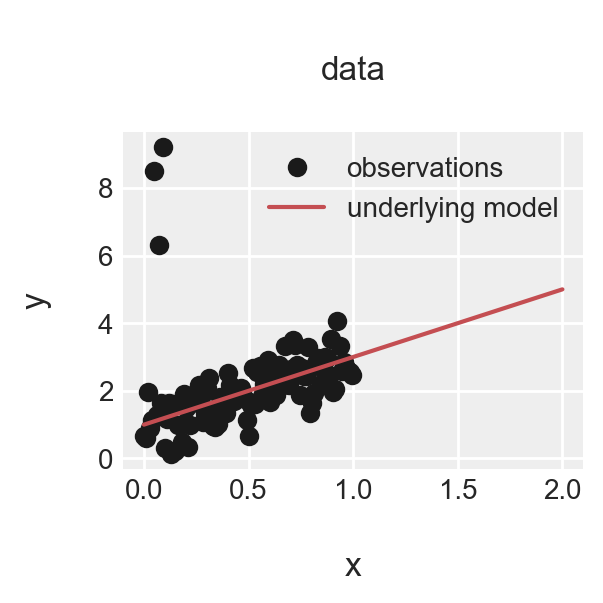

In [17]:
ax = relational.figure(width=2.9, height=2.9)
ax.plot(data.independent, data.dependent, 'ko', label='observations')
ax.plot(data.abscissae, data.ordinates, 'r-', label='underlying model')

relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\ndata\n', '\nx', 'y\n']))

ax.legend(loc='upper right', fontsize='small');

<br>

The distribution of the observations

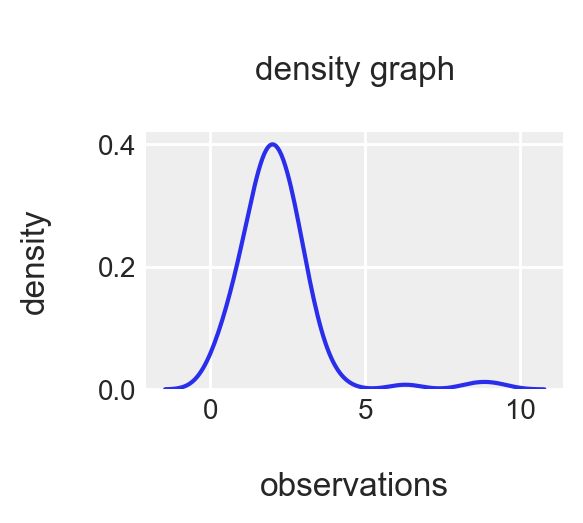

In [18]:
ax = relational.figure(width=2.8, height=2.5)
sns.kdeplot(data=data.dependent, legend=False)

relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\ndensity graph\n', '\nobservations', 'density\n']))

<br>
<br>

# Modelling

In [19]:
import fundamentals.regression.linear.predictions
import fundamentals.regression.linear.characteristics

## Student

**Hypothesis**:  Linear underlying model.

Modelling via **Student's t-distribution Likelihood Model**, and noting that the term **weights** refers to the parameters of a model, i.e., $\:m$ & $c\:$ in $\:y = mx + c$.  The hyperpriors of the **Student's t-distribution Likelihood Model** are $\sigma$ & $\nu$, i.e., if the t-distribution is denoted

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $ \mathcal{St} \left(x | \mu, \nu, \lambda \approx \large{\frac{1}{\sigma^{2}}} \right) $

then

* $\sigma$ & $\nu$ are the likehood model's hyperparameters
* $\mu$ is the data model estimator such that $\; \mu$ = pm.Deterministic(name=$\mu$, mx + c))

In the case of **stochastic weights**

* $m \sim \mathcal{GaussianRandomWalk()}$
* $c \sim \mathcal{GaussianRandomWalk()}$

whereas the set-up for **Gaussian weights** is

* $m \sim \mathcal{N}()$
* $c \sim \mathcal{N}()$

i.e., each is modelled via a normal, i.e., Gaussian, distribution.

<br>
<br>

### Student Likelihood, Stochastic Weights

In [20]:
import fundamentals.regression.linear.student.stochastic

In [21]:
s_stochastic = fundamentals.regression.linear.student.stochastic.Stochastic(
    independent=data.independent, dependent=data.dependent).inference()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_, sigma_, intercept, interceptDeviation, interceptDrift, gradient, gradientDeviation, gradientDrift]
INFO:pymc3:NUTS: [nu_, sigma_, intercept, interceptDeviation, interceptDrift, gradient, gradientDeviation, gradientDrift]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.
INFO:pymc3:Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.


<br>

DAG

In [22]:
fundamentals.regression.linear.characteristics.Characteristics(
    model=s_stochastic.model, trace=s_stochastic.trace).dag_(path=os.path.join(pathofdiagrams, 's_stochastic'))

<br>

Predictions

In [23]:
ssp = fundamentals.regression.linear.predictions.Predictions(
    trace=s_stochastic.trace, maximal=s_stochastic.maximal, abscissae=data.abscissae, size=75).exc()

In [24]:
logger.info([ssp.line.shape, ssp.lines.shape, ssp.posterior.shape])

INFO:__main__:[(200, 1), (200, 75), (200, 1)]


<br>
<br>

### Student Likelihood, Gaussian Weights

In [25]:
import fundamentals.regression.linear.student.gaussian

In [26]:
s_gaussian = fundamentals.regression.linear.student.gaussian.Gaussian(
    independent=data.independent, dependent=data.dependent).inference()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_, sigma_, intercept, gradient]
INFO:pymc3:NUTS: [nu_, sigma_, intercept, gradient]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.
INFO:pymc3:Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.


<br>

DAG

In [27]:
fundamentals.regression.linear.characteristics.Characteristics(
    model=s_gaussian.model, trace=s_gaussian.trace).dag_(path=os.path.join(pathofdiagrams, 's_gaussian'))

<br>

Predictions

In [28]:
sgp = fundamentals.regression.linear.predictions.Predictions(
    trace=s_gaussian.trace, maximal=s_gaussian.maximal, abscissae=data.abscissae, size=75).exc()

In [29]:
logger.info([sgp.line.shape, sgp.lines.shape, sgp.posterior.shape])

INFO:__main__:[(200, 1), (200, 75), (200, 1)]


<br>
<br>

## Gaussian

### Gaussian Likelihood, Gaussian Weights

In [30]:
import fundamentals.regression.linear.gaussian.gaussian

In [31]:
g_gaussian = fundamentals.regression.linear.gaussian.gaussian.Gaussian(
    independent=data.independent, dependent=data.dependent).inference()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, gradient]
INFO:pymc3:NUTS: [sigma, intercept, gradient]


Sampling 4 chains for 10_000 tune and 4_000 draw iterations (40_000 + 16_000 draws total) took 52 seconds.
INFO:pymc3:Sampling 4 chains for 10_000 tune and 4_000 draw iterations (40_000 + 16_000 draws total) took 52 seconds.


<br>

DAG

In [32]:
fundamentals.regression.linear.characteristics.Characteristics(
    model=g_gaussian.model, trace=g_gaussian.trace).dag_(path=os.path.join(pathofdiagrams, 'g_gaussian'))

<br>

Predictions

In [33]:
ggp = fundamentals.regression.linear.predictions.Predictions(
    trace=g_gaussian.trace, maximal=g_gaussian.maximal, abscissae=data.abscissae, size=75).exc()

In [34]:
logger.info([ggp.line.shape, ggp.lines.shape, ggp.posterior.shape])

INFO:__main__:[(200, 1), (200, 75), (200, 1)]


<br>
<br>

# Analysis

<br>

**Comparative Analysis of Models**

In [35]:
mca = az.compare({'student, gaussian parameters': s_gaussian.arviztrace, 
                  'student, stochastic parameters': s_stochastic.arviztrace, 
                  'gaussian, gaussian parameters': g_gaussian.arviztrace},
                 b_samples=10000, ic='loo', scale='deviance')


J:\Programs\Anaconda3\envs\uncertainty\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


In [36]:
mca

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
"student, stochastic parameters",0,229.327,5.09167,0,0.540583,29.2381,0,False,deviance
"student, gaussian parameters",1,229.651,5.26093,0.324404,0.459417,29.2082,0.0886274,False,deviance
"gaussian, gaussian parameters",2,354.956,14.3313,125.629,2.54196e-16,56.0416,32.6375,True,deviance


<br>

**Graphs**

In [51]:
title_ = ('student likelihood\nstochastic weights', 'student likelihood\ngaussian weights', 'gaussian likelihood\ngaussian weights')
predictions_ = (ssp, sgp, ggp)

assert len(title_) == len(predictions_), 'The variables title & predictions must have the same length.'

In [50]:
import fundamentals.regression.linear.graphs

In [52]:
graphs = fundamentals.regression.linear.graphs.Graphs(data=data, predictions_=predictions_, title_=title_)

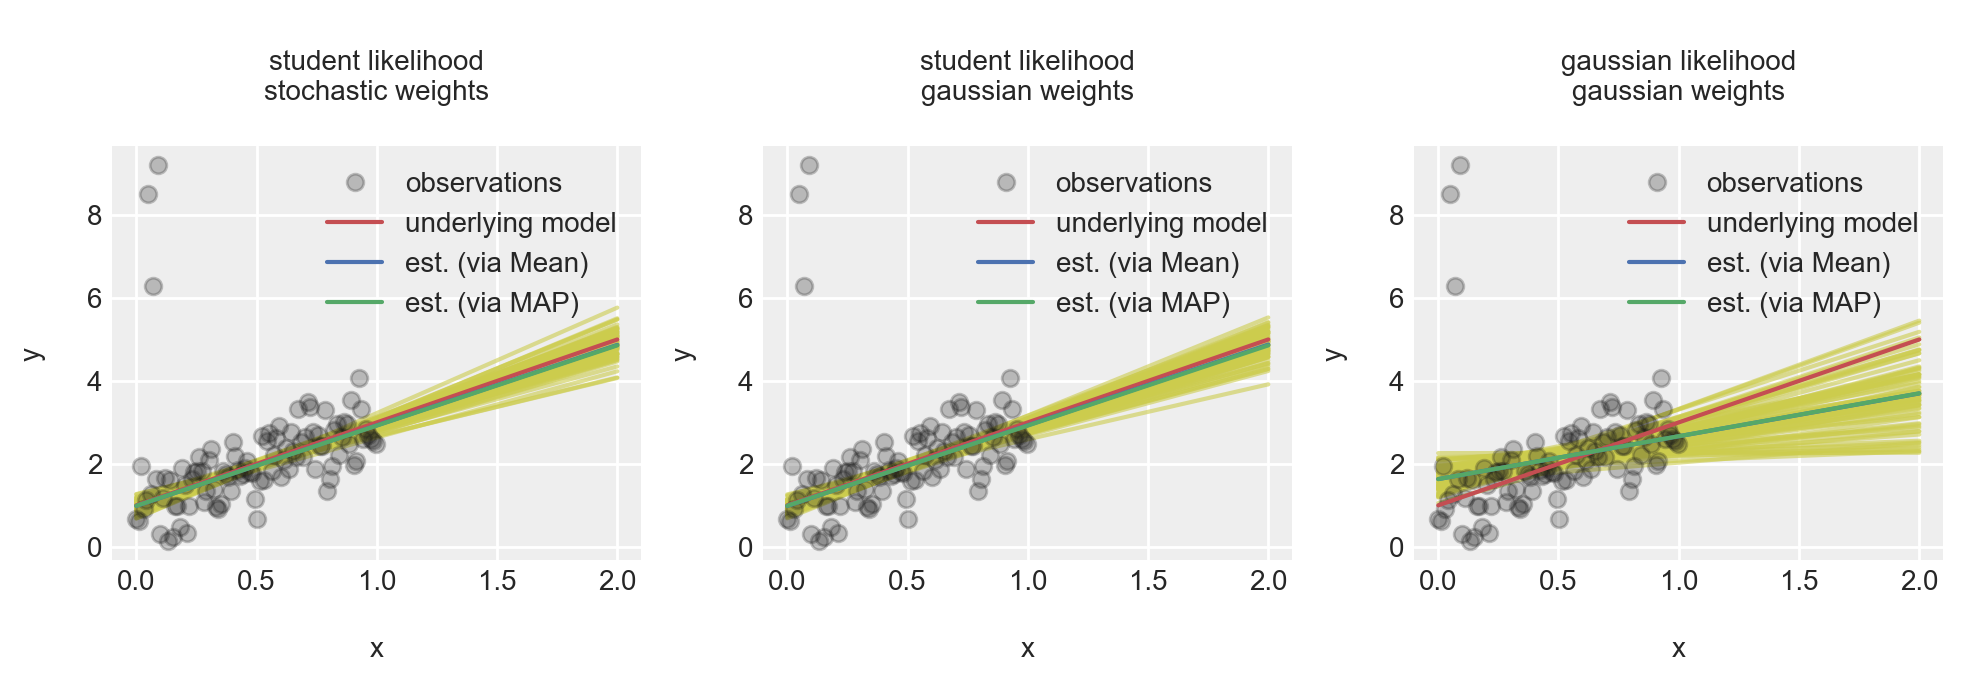

In [53]:
graphs.exc()